You need to have python and pandas, this enviroment uses ...

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [57]:
data = pd.read_csv('data/AmesHousing.csv')
print(data.head())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0       

In [58]:
# Basic information about the dataset
print(data.describe())
print(data.info())

# Check for missing values
print(data.isnull().sum())


            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96247  1.887308e+08    42.638025     23.365335    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     58.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     80.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2930.000000   2930.000000  2930.000000     2930.000000   2907.000000   
mean       6.094881      5.563140  1971.356314     1984.266553    101.896801   
std        1.411026      1.111537    30.245361       20.860286    

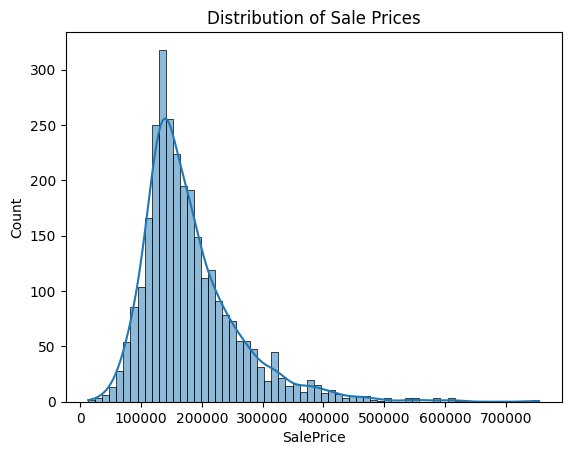

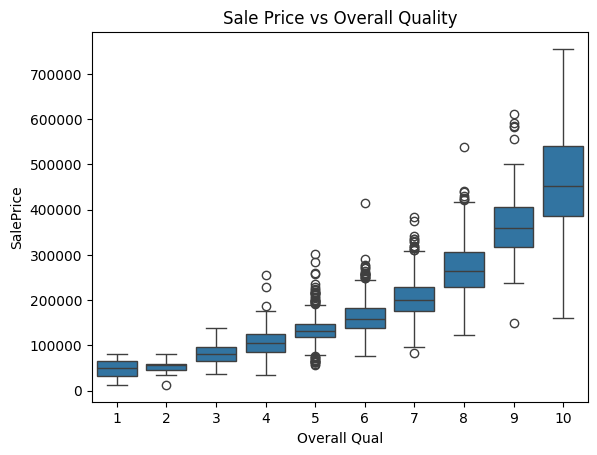

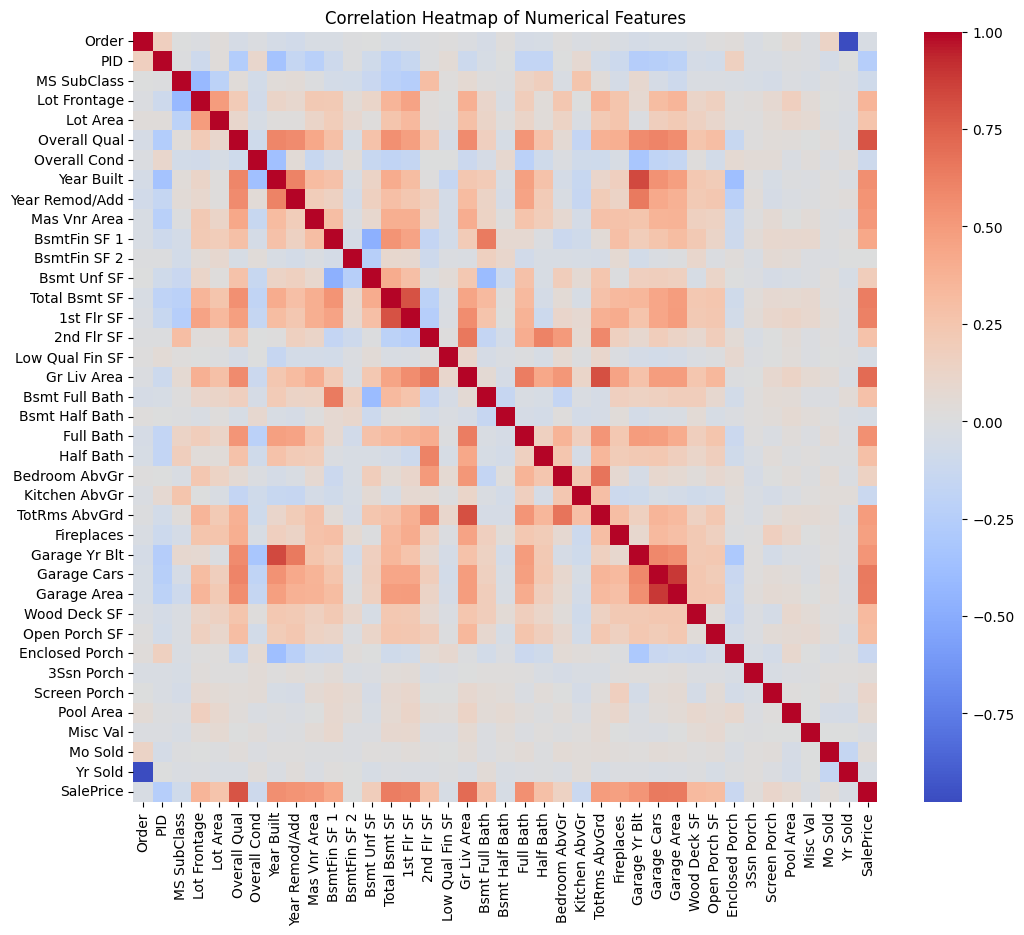

In [59]:
sns.histplot(data['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.show()

# Relationship between 'OverallQual' and 'SalePrice'
sns.boxplot(x='Overall Qual', y='SalePrice', data=data)
plt.title('Sale Price vs Overall Quality')
plt.show()

# Correlation heatmap for numerical features
corr_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Important features
From the heat map above you can see how much the different features correlates with the sale price. The most important features are: 
- OverallQual
- GrLivArea
- GarageCars
- GarageArea

In [60]:
# Filling missing values with the median for numerical columns and mode for categorical columns
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna(data[column].mode()[0])
    else:
        data[column] = data[column].fillna(data[column].median())

# Creating a new feature 'TotalSF' that sums up all square footage
data['TotalSF'] = data['1st Flr SF'] + data['2nd Flr SF'] + data['Total Bsmt SF']

# Convert categorical variables using one-hot encoding
data = pd.get_dummies(data)

In [61]:
# Finding highly correlated features
high_corr_features = corr_matrix['SalePrice'].sort_values(ascending=False)
strong_corr_features = high_corr_features[abs(high_corr_features) > 0.5].index.tolist()
print("Strongly correlated features:", strong_corr_features)
extra_strong_corr_features = high_corr_features[abs(high_corr_features) > 0.7].index.tolist()
print("Extra strongly correlated features:", extra_strong_corr_features)

Strongly correlated features: ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath', 'Year Remod/Add', 'Garage Yr Blt', 'Mas Vnr Area']
Extra strongly correlated features: ['SalePrice', 'Overall Qual', 'Gr Liv Area']


### Filtered correlation data
By filtering the correlation features at the score 0.5 we can see that we get 11 features.
0.5 is a good score to filter by since it gives us a good amount of features to work with and the features are also highly correlated with the sale price.

By filtering the correlation features at the score 0.7 or greater we can see that the most important features are:
- OverallQual
- GrLivArea

Which could also be good selection of features to work with, but since we only get 2 features it might be a bit to few to work with.

Linear Regression Results:
MAE: 24177.83501111923
MSE: 1460524044.0779362
R2: 0.8178340738759297

Polynomial Regression Results (Degree 2):
MAE: 20077.371141501124
MSE: 1168086011.4713414
R2: 0.8543088209091518

Random Forest Regressor Results:
MAE: 18138.139742293733
MSE: 994959722.626445
R2: 0.8759022420320232

Gradient Boosting Regressor Results:
MAE: 18322.490947566585
MSE: 911915133.8404467
R2: 0.8862600957675599


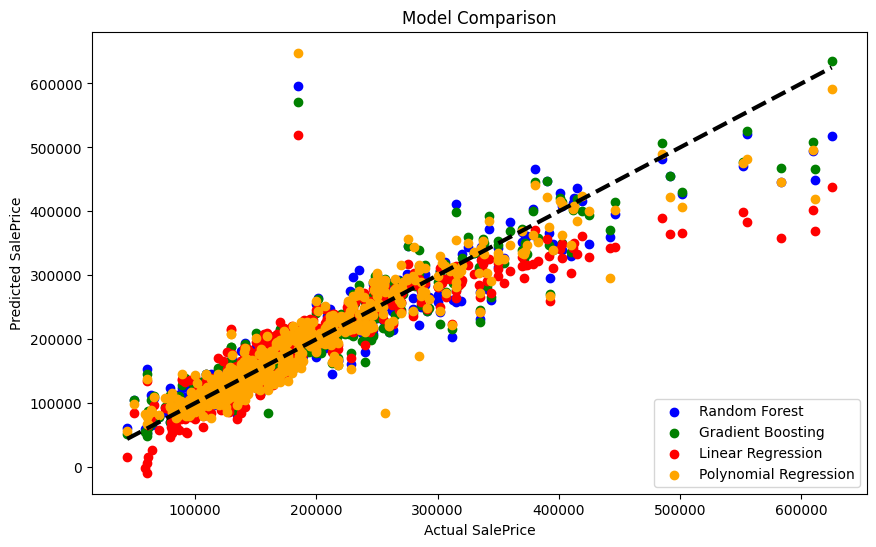

In [62]:
# Prepare data for modeling
X = data[strong_corr_features].drop('SalePrice', axis=1)
y = data['SalePrice']
# Split the data to be able to test it later.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale features as explained in lecture
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr)}")
print(f"R2: {r2_score(y_test, y_pred_lr)}")

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

y_pred_poly = lr_poly.predict(X_test_poly)
print()
print("Polynomial Regression Results (Degree 2):")
print(f"MAE: {mean_absolute_error(y_test, y_pred_poly)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_poly)}")
print(f"R2: {r2_score(y_test, y_pred_poly)}")

# RandomforestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print()
print("Random Forest Regressor Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"R2: {r2_score(y_test, y_pred_rf)}")

# GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)
print()
print("Gradient Boosting Regressor Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gbr)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_gbr)}")
print(f"R2: {r2_score(y_test, y_pred_gbr)}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', label='Random Forest')
plt.scatter(y_test, y_pred_gbr, color='green', label='Gradient Boosting')
plt.scatter(y_test, y_pred_lr, color='red', label='Linear Regression')
plt.scatter(y_test, y_pred_poly, color='orange', label='Polynomial Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Model Comparison")
plt.legend()
plt.show()


### Reflections about output
From the output above we can see that all models gets a score higher than 0.8. From the graph we can see that the green model, Gradient Boosting, seems to be better; especially at higher SalePrice values.

Since all the models got such a high score we want to also try the models using only the most important features and see the results:

Linear Regression Results:
MAE: 30203.09943875193
MSE: 2055415555.9816177
R2: 0.743635389062289

Polynomial Regression Results (Degree 2):
MAE: 26579.777622582085
MSE: 1539814126.2846785
R2: 0.8079445062811943

Random Forest Regressor Results:
MAE: 28710.461023964497
MSE: 1896049821.9076397
R2: 0.7635125055382156

Gradient Boosting Regressor Results:
MAE: 26014.50966168696
MSE: 1799470240.9489846
R2: 0.7755585303067536


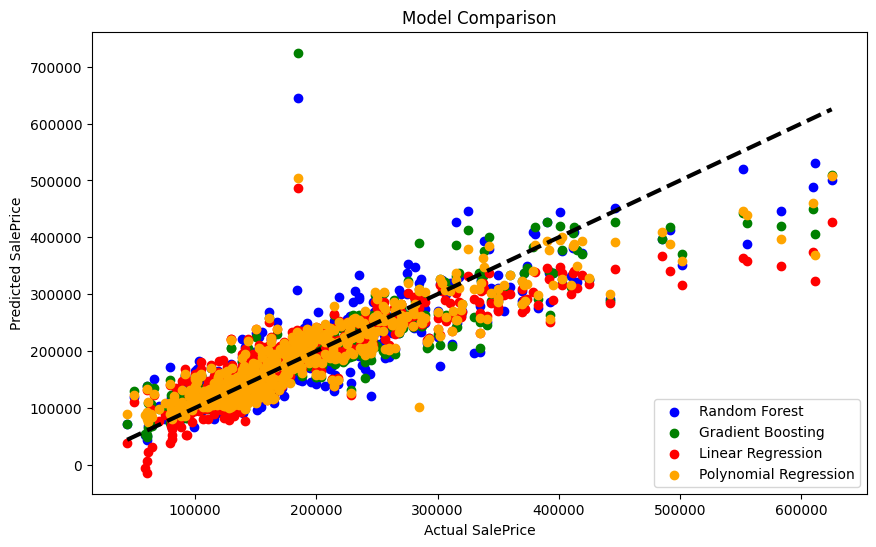

In [63]:
# Prepare data for modeling
X = data[extra_strong_corr_features].drop('SalePrice', axis=1)
y = data['SalePrice']
# Split the data to be able to test it later.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale features as explained in lecture
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr)}")
print(f"R2: {r2_score(y_test, y_pred_lr)}")

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

y_pred_poly = lr_poly.predict(X_test_poly)
print()
print("Polynomial Regression Results (Degree 2):")
print(f"MAE: {mean_absolute_error(y_test, y_pred_poly)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_poly)}")
print(f"R2: {r2_score(y_test, y_pred_poly)}")

# RandomforestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print()
print("Random Forest Regressor Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"R2: {r2_score(y_test, y_pred_rf)}")

# GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)
print()
print("Gradient Boosting Regressor Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gbr)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_gbr)}")
print(f"R2: {r2_score(y_test, y_pred_gbr)}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', label='Random Forest')
plt.scatter(y_test, y_pred_gbr, color='green', label='Gradient Boosting')
plt.scatter(y_test, y_pred_lr, color='red', label='Linear Regression')
plt.scatter(y_test, y_pred_poly, color='orange', label='Polynomial Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Model Comparison")
plt.legend()
plt.show()

### Reflections about the models with correlation scores above 0.7
From the output above, where we ran the models using only the features "OverallQual" and "GrLivArea", we can see that the models get a score of arround 0.75-0.8 which is slighy lower than the models with correlation scores above 0.5. This is probably because we only use 2 features in the models, which is too few to get a good prediction. With these features we can also see that Polynomial Regression is the best model to use.

We therefore conclude that the selected features with correlation scores above 0.5 are better to use in the models.